_Authors: "Shuyu Wu and Marc Inizan"_

### Defining most important factors in  Life Expectancy in the USA
For this project we will use the **Cross Industry Standard Process for Data Mining (Crisp-DM)** as our methodology to process the data we'll be working on.

Given the number of features available in our datasets we should first make sure that our data is complete enough for each feature (having a low amount of missing values).
And fill the missing values with the most appropriate values. 
In our case it makes sens to use weighted averages by state populations.

Once our data is clean we can process with the following tasks:

- Transform the features that have a very skewed distribution using log transformation
- Drop features that having high multicollinearity (over 75%)
- Split our dataset into train and test datasets
- Build a Baseline model: Using Scikit-Learn's LinearRegression and cross-validation
- Do some feature engineering using interactions and polynomials
- We then proceed to normalize our data in order have features on the same scale to be able to judge the impact of a specific feature versus another one
- Run different models using Lasso regression
- Chose the best model and finally use it on our test dataset
- Build meaningful visualizations

Then we'll have a look at our model's coefficents to determine what are the most important features impacting life expectancy.

Finally we'll propose solutions to improve life expectancy in the USA and show meaningful visualizations to locate areas where the focus should be.

### Importing libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from external_modules.functions import *
from pprint import pprint
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import levene
import plotly.figure_factory as ff
import plotly.express as px
import json
from collections import OrderedDict
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

#### Importing Dataset

In [2]:
ls

Data/              marc_index.ipynb  presentation.pdf  README.md
external_modules/  Pictures/         __pycache__/      shuyu_index.ipynb


### If the cleaning process has already been done jump to import the cleaned csv later in the file

In [3]:
xls = pd.ExcelFile('Data/2019 County Health Rankings Data - v2.xls')
df = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [4]:
df.head()

,FIPS,State,County,Life Expectancy,95% CI - Low,95% CI - High,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,...,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.16,95% CI - High.16,% Female,# Rural,% Rural
0,1001,Alabama,Autauga,76.330589,75.554117,77.107061,74.600628,NaN,76.337219,815.0,...,2.857452,41336,74.473912,430,0.828548,0.422472,1.234624,51.342246,22921.0,42.002162
1,1003,Alabama,Baldwin,78.599498,78.208357,78.990639,75.628919,98.039893,78.537003,2827.0,...,4.550200,176582,83.047388,872,0.454512,0.282144,0.626880,51.452772,77060.0,42.279099
2,1005,Alabama,Barbour,75.779457,74.639355,76.919559,74.240228,NaN,77.568384,451.0,...,4.206569,11613,45.955679,297,1.199273,0.580536,1.818011,47.229917,18613.0,67.789635
3,1007,Alabama,Bibb,73.928271,72.624611,75.231931,72.294686,NaN,74.109510,445.0,...,2.638080,16842,74.298571,84,0.394348,0.000000,0.933361,46.453150,15663.0,68.352607
4,1009,Alabama,Blount,74.597767,73.810999,75.384535,NaN,78.577094,74.098247,1050.0,...,9.565097,50439,86.944306,1013,1.870004,1.364180,2.375829,50.688639,51562.0,89.951502


In [5]:
df.select_dtypes(include=['object'])[:2]

,State,County,Other PCP Ratio
0,Alabama,Autauga,3265:1
1,Alabama,Baldwin,1916:1


### Exploratory Data Analysis

#### Renaming columns

In [6]:
columns_name = df.columns
new_column_names = []
for column_name in columns_name:
    new_column_names.append(column_name.replace(" ", "_"))
pprint(new_column_names[:5])
df.columns = new_column_names

['FIPS', 'State', 'County', 'Life_Expectancy', '95%_CI_-_Low']


#### Renaming counties

In [7]:
county_names = df["County"]
new_county_names = []
for county_name in county_names:
    new_county_names.append(county_name.replace(" ", "_"))
df["County"] = new_county_names

#### Dropping ethnicies columns and columns with a lot of missing values

In [8]:
to_drop = ["Other_PCP_Ratio", "FIPS", "Segregation_index", "Segregation_Index" , "%_Free_or_Reduced_Lunch", "#_HIV_Cases", "HIV_Prevalence_Rate"]
#Data is missing for HIV only in South Dakota, replace it by country weighted average later or look at this column in depth
containing = ["CI_-_Low", "CI_-_High", "#_","White", "Hispanic", "Black", "Asian" ,"Alaskan", "Indian", "Hawaiian", "African"]
for column in df.columns:
    if (column in to_drop) or any(word in column for word in containing):
        df = df.drop([column], axis=1)

In [9]:
df.columns

Index(['State', 'County', 'Life_Expectancy', 'Age-Adjusted_Mortality',
       'Child_Mortality_Rate', 'Infant_Mortality_Rate',
       '%_Frequent_Physical_Distress', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured', '%_Uninsured.1',
       'Other_PCP_Rate', '%_Disconnected_Youth', 'Household_Income',
       'Homicide_Rate', 'Firearm_Fatalities_Rate', '%_Homeowners',
       '%_Severe_Housing_Cost_Burden', 'Population', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Female', '%_Rural'],
      dtype='object')

In [10]:
ren_col = {"Household_Income": "Household_Median_Income",
           "%_Uninsured": "%_Uninsured_adults",
           "%_Uninsured.1" : "%_Uninsured_children",
           "%_Limited_Access": "%_Limited_Access_Healthy_Food"}

In [11]:
df.rename(columns=ren_col, inplace=True)

#### Delete rows missing Life Expectancy

In [12]:
df = df.dropna(subset=["Life_Expectancy"])

### Fill counties missing values using states weighted averages

In [13]:
df.head(2)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099


#### Calculate the weighted averages for each columns in each states

In [14]:
states = list(df.State.unique())
columns = [x for x in list(df.columns) if x not in ["State", "County"]]

In [15]:
state_wv = {}
for state in states:
    df_state = df.loc[df["State"] == state]
    for column in columns:
        values = df_state.dropna(subset=[column])[column]
        population_value = df_state.dropna(subset=[column])["Population"].astype(np.float64)
        population = np.sum(df_state.dropna(subset=[column])["Population"])
        if population != 0:
            wv = (values * population_value).sum() / population
            if not state_wv.get(state):
                state_wv[state] = {}
            state_wv[state][column] = float(wv)
        else:
            print(f"No data for {column} in {state}")

#### Fill each missing values by states weighted averages

In [16]:
df_filled = df.copy()
for index in df.index:
    for column in df.columns:
        if column not in ["State","County"]:
            if np.isnan(df[column][index]):
                df_filled[column][index] = state_wv[df["State"][index]][column]

In [17]:
df_filled.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


#### Saving cleaned DataFrame to csv file

In [18]:
df_filled.to_csv(r"/home/locsta/Documents/FlatIron/County-Health-Analysis/Data/clean.csv", index=False)

#### Saving dictionnary for States weighted averages in a Json file

In [19]:
with open('Data/state_wv.json', 'w') as f:
    json.dump(state_wv, f)

### Importing Cleaned CSV

In [20]:
df = pd.read_csv("Data/clean.csv")
df.head(3)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635


#### Plot variables distribution

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



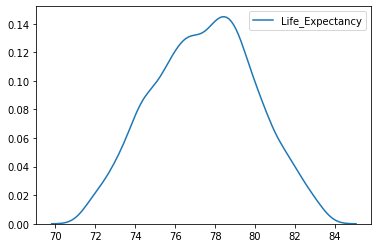

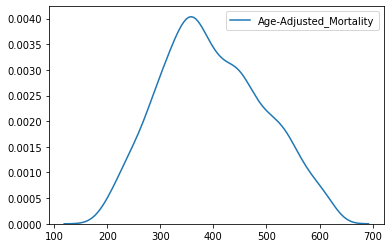

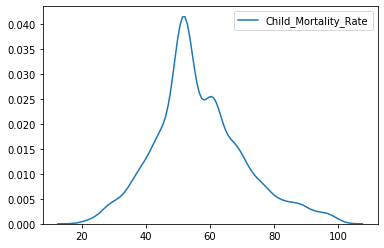

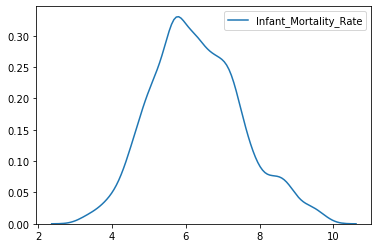

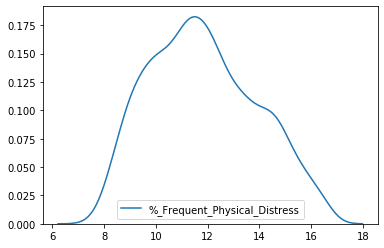

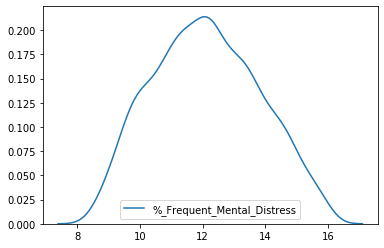

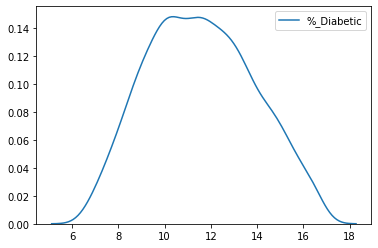

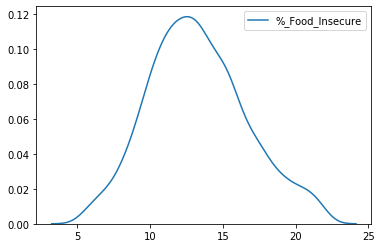

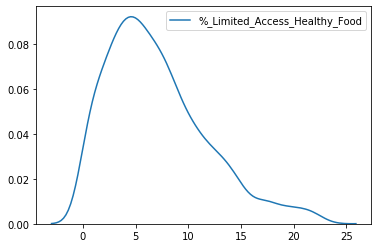

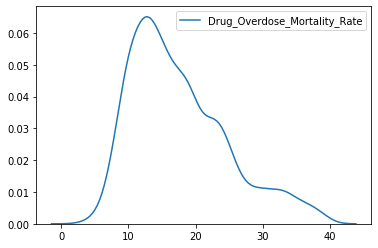

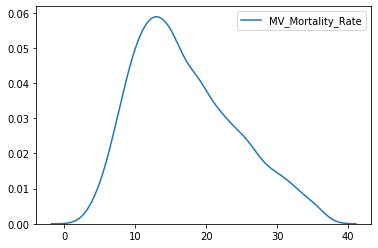

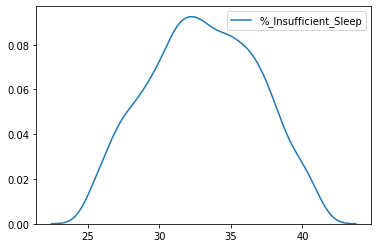

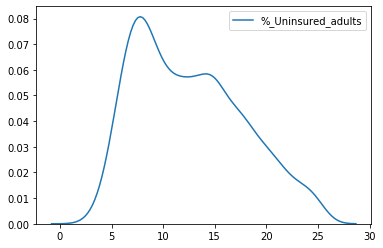

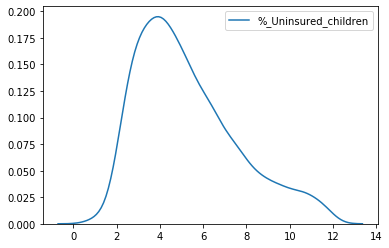

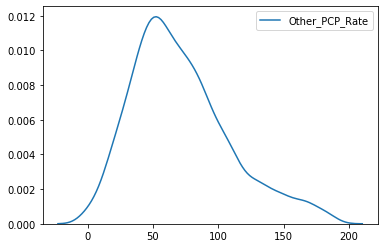

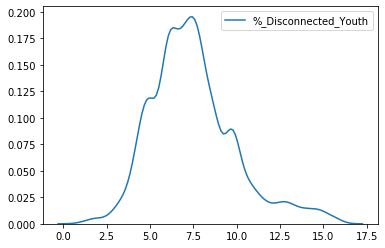

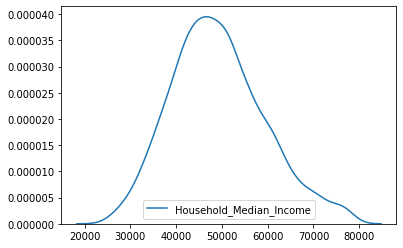

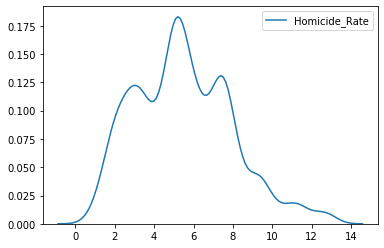

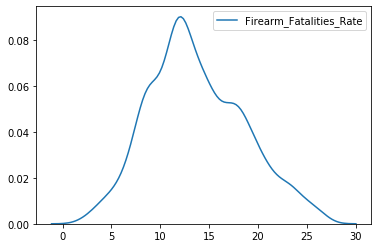

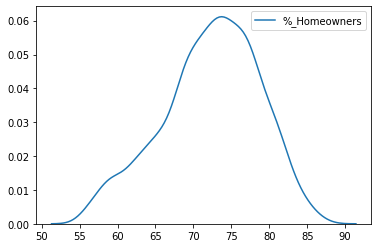

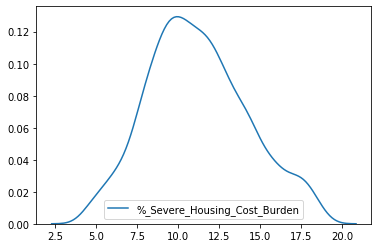

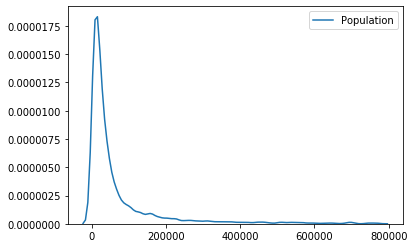

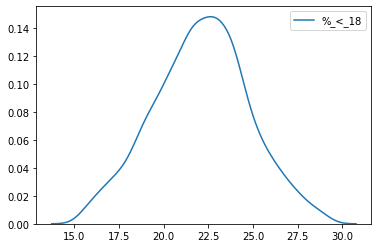

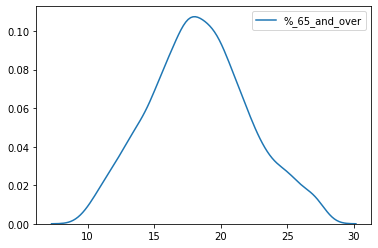

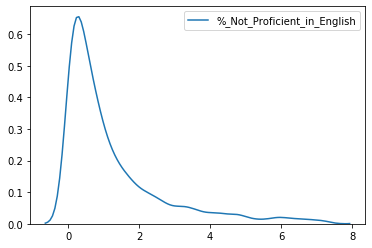

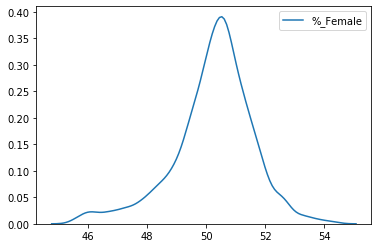

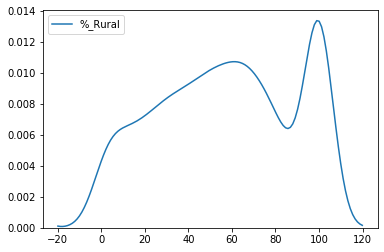

In [21]:
for i, column in enumerate(df.drop(["State", "County"], axis=1).columns):
    plt.figure(i)
    min_x = (df[column].mean()-(2*df[column].std()))
    max_x = (df[column].mean()+(2*df[column].std()))
    sns.kdeplot(df[column], clip=(min_x, max_x))

#### Transform numerical columns using log

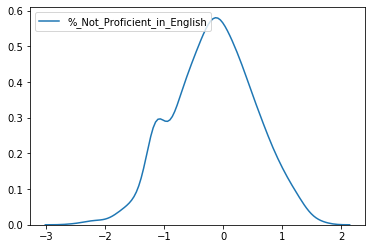

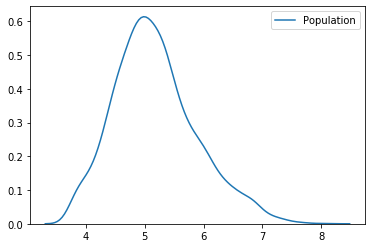

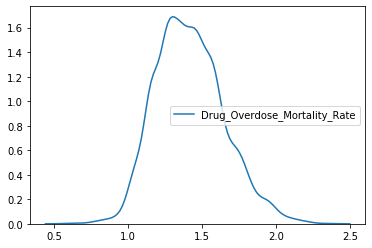

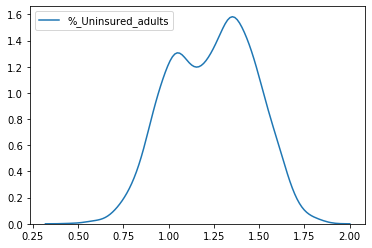

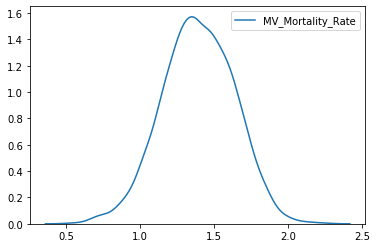

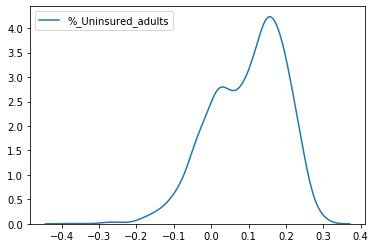

In [22]:
to_log = ["%_Not_Proficient_in_English", "Population" ,"Drug_Overdose_Mortality_Rate", "%_Uninsured_adults","MV_Mortality_Rate", "%_Uninsured_adults"]
# to_categories = ["Other_PCP_Rate","Population", "%_Rural"] #Maybe!
# ["%_Limited_Access_Healthy_Food"]   <= to many std away from mean at the lower end of the tail
for i, column in enumerate(to_log):
    df[column]=df[column].replace(0,0.1)
    df[column] = df[column].map(lambda x: np.log(np.sqrt(x)))
    plt.figure(i)
    sns.kdeplot(df[column])

#### Turn State column into category and drop County

In [23]:
df["State"] = df["State"].astype('category')
df = df.drop(["County"], axis=1)

#### Creating dummy variables

In [24]:
df["State"] = df["State"].cat.codes

#### Verify non multicollinearity over 75%

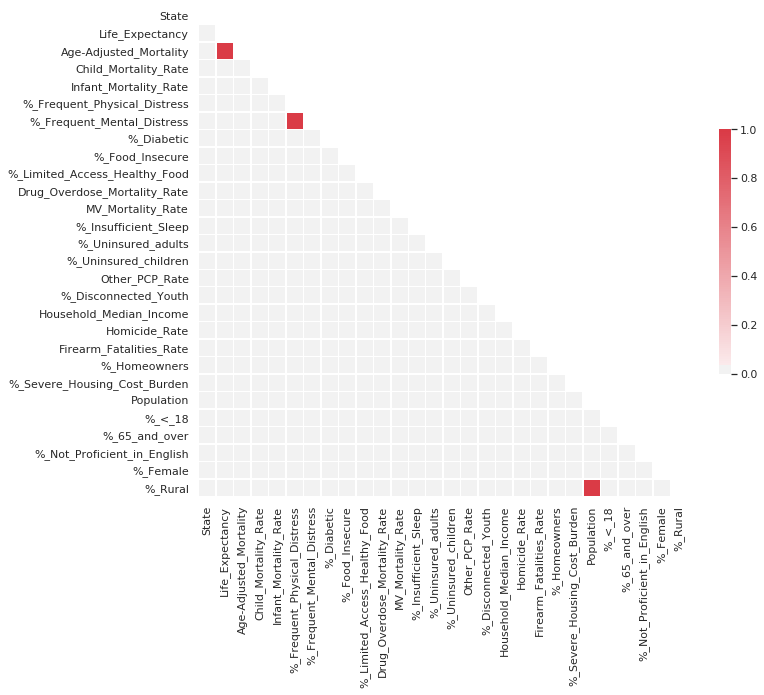

In [25]:
print_corr(df, 0.75)

#### Dropping highly correlated features

In [26]:
to_drop = ["Age-Adjusted_Mortality", "%_Frequent_Physical_Distress", "Population"]
for col in to_drop:
    df = df.drop([col], axis=1)

#### Checking p-values

In [27]:
results, columns_to_drop = p_dropping(df, target="Life_Expectancy", p_value=0.05)

/home/locsta/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [28]:
columns_to_drop

['Life_Expectancy',
 '%_Female',
 '%_Uninsured_adults',
 '%_Disconnected_Youth',
 'Infant_Mortality_Rate',
 '%_Homeowners']

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     370.1
Date:                Fri, 24 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:44:01   Log-Likelihood:                -5901.0
No. Observations:                3073   AIC:                         1.184e+04
Df Residuals:                    3053   BIC:                         1.196e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            90.8625      0.775    117.192      0.000      89.342      92.383
State                            -0.0086      0.002     -3.890      0.000      -0.013      -0.004
Child_Mortality_Rate             -0.0163      0.002     -8.525      0.000      -0.020      -0.013
%_Frequent_Mental_Distress       -0.1128      0.034     -3.294      0.001      -0.180      -0.046
%_Diabetic                       -0.2046      0.022     -9.431      0.000      -0.247      -0.162
%_Food_Insecure                  -0.0830      0.013     -6.147      0.000      -0.109      -0.057
%_Limited_Access_Healthy_Food     0.0130      0.004      2.933      0.003       0.004       0.022
Drug_Overdose_Mortality_Rate     -1.6108      0.166     -9.733      0.000      -1.935      -1.286
MV_Mortality_Rate                -2.4838      0.186    -13.333      0.000      -2.849      -2.119
%_Insufficient_Sleep             -0.0677      0.013     -5.099      0.000      -0.094      -0.042
%_Uninsured_children              0.0471      0.013      3.669      0.000       0.022       0.072
Other_PCP_Rate                   -0.0029      0.001     -5.142      0.000      -0.004      -0.002
Household_Median_Income        5.307e-05   3.86e-06     13.737      0.000    4.55e-05    6.06e-05
Homicide_Rate                     0.0333      0.012      2.809      0.005       0.010       0.057
Firearm_Fatalities_Rate          -0.0374      0.006     -5.769      0.000      -0.050      -0.025
%_Severe_Housing_Cost_Burden      0.0291      0.011      2.536      0.011       0.007       0.052
%_<_18                           -0.1539      0.013    -11.709      0.000      -0.180      -0.128
%_65_and_over                     0.0427      0.011      3.721      0.000       0.020       0.065
%_Not_Proficient_in_English       0.4839      0.058      8.282      0.000       0.369       0.599
%_Rural                           0.0089      0.001      6.127      0.000       0.006       0.012
==============================================================================
Omnibus:                      696.054   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9083.580
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                      11.306   Cond. No.                     1.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Dropping columns with high p-values

In [30]:
for col in columns_to_drop:
    if col == "Life_Expectancy":
        continue
    df = df.drop([col], axis=1)

### Checking normality assumption

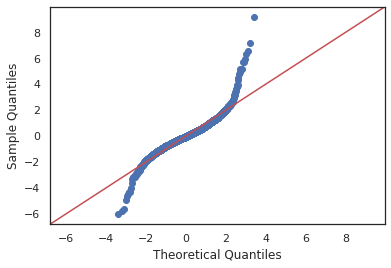

In [31]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)

In [32]:
rows_b = len(df)
df = df[df["Life_Expectancy"] < np.percentile(df["Life_Expectancy"],95)]
rows_a = len(df)
r_dropped = rows_b - rows_a

Removing the top 5% values for Life Expectancy removed 154 rows (0.05%)


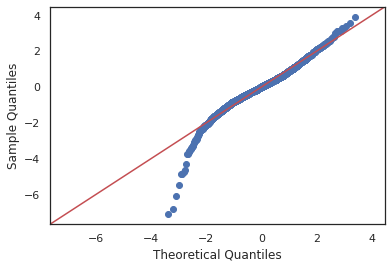

In [33]:
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
print(f"Removing the top 5% values for Life Expectancy removed {r_dropped} rows ({round(r_dropped/rows_b, 2)}%)")

In [34]:
rows_b = len(df)
df = df[df["Life_Expectancy"] > np.percentile(df["Life_Expectancy"],5)]
rows_a = len(df)
r_dropped = rows_b - rows_a

Removing the bottom 5% values for Life Expectancy removed 146 rows (0.05%)


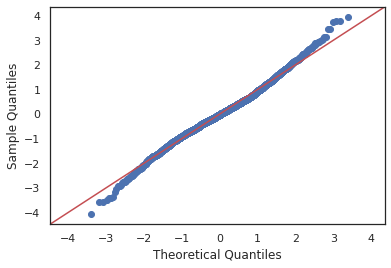

In [35]:
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
print(f"Removing the bottom 5% values for Life Expectancy removed {r_dropped} rows ({round(r_dropped/rows_b, 2)}%)")

### Check Homoscedasticity Assumption

In [36]:
t, p = levene(results.predict(X), df["Life_Expectancy"])
print(f"t-stat: {t}, p-value: {p}")
print("The predictions and real values DON'T have the same variance") if p > 0.05 else print("The predictions and real values have the same variance")

t-stat: 144.7413885377846, p-value: 6.271332902283854e-33
The predictions and real values have the same variance


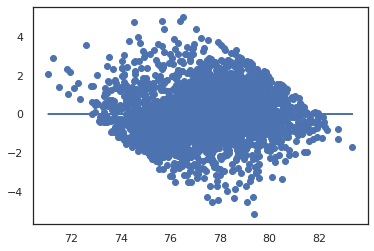

In [37]:
plt.scatter(results.predict(X), results.resid)
plt.plot(results.predict(X), [0 for i in range(len(df))])

### Split the data into train and test

In [38]:
#Use Life_Expectancy as Target and the other columns has parameters
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Life_Expectancy"], axis=1).astype('float'), df["Life_Expectancy"].astype('float'), test_size=0.25, random_state=42)

In [39]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Cross-validation

In [40]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=10)
baseline = np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation))
print(f"The baseline R-Squared is {baseline}")

The baseline R-Squared is 0.6726282138560578


### Feature Engineering

#### Interactions

In [41]:
from itertools import combinations
combinations = list(combinations(X_train.columns, 2))

In [42]:
interactions = []
data = X_train.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            
print('Top 7 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])
data = data.drop(["interaction"], axis=1)

Top 7 interactions: [('%_Diabetic', '%_Insufficient_Sleep', 0.681), ('State', '%_Uninsured_children', 0.677), ('%_Diabetic', 'Homicide_Rate', 0.677), ('%_Diabetic', '%_<_18', 0.677), ('%_Food_Insecure', '%_Insufficient_Sleep', 0.677), ('%_Food_Insecure', '%_Severe_Housing_Cost_Burden', 0.677), ('%_Food_Insecure', '%_<_18', 0.677)]


#### Adding top 3 interactions to train and test datasets

In [43]:
X_train["Diabetic*Insufficient_Sleep"] = X_train["%_Diabetic"] * X_train["%_Insufficient_Sleep"]
X_train["Food_Insecure*%_Severe_Housing_Cost_Burden"] = X_train["%_Food_Insecure"] * X_train["%_Severe_Housing_Cost_Burden"]
X_train["%_Food_Insecure*%_Insufficient_Sleep"] = X_train["%_Food_Insecure"] * X_train["%_Insufficient_Sleep"]
X_test["Diabetic*Insufficient_Sleep"] = X_test["%_Diabetic"] * X_test["%_Insufficient_Sleep"]
X_test["Food_Insecure*%_Severe_Housing_Cost_Burden"] = X_test["%_Food_Insecure"] * X_test["%_Severe_Housing_Cost_Burden"]
X_test["%_Food_Insecure*%_Insufficient_Sleep"] = X_test["%_Food_Insecure"] * X_test["%_Insufficient_Sleep"]

In [44]:
print(len(X_train),len(y_train), len(X_test), len(y_test), len(X_train.columns), len(X_test.columns))

2079 2079 694 694 22 22


In [45]:
X_train.columns

Index(['State', 'Child_Mortality_Rate', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access_Healthy_Food',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured_children', 'Other_PCP_Rate',
       'Household_Median_Income', 'Homicide_Rate', 'Firearm_Fatalities_Rate',
       '%_Severe_Housing_Cost_Burden', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Rural', 'Diabetic*Insufficient_Sleep',
       'Food_Insecure*%_Severe_Housing_Cost_Burden',
       '%_Food_Insecure*%_Insufficient_Sleep'],
      dtype='object')

#### Polynomials

In [46]:
polynomials = []
columns = list(X_train.drop(["State"], axis=1).columns)
for col in columns:
    for degree in [2, 3, 4]:
        #Copy the X_train set
        X_ = X_train.drop(["State"], axis=1).copy()
        
        #Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree, include_bias=False)

        #Fit and transform X_train
        X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
        X_ = pd.concat([X_.drop(col, axis=1),pd.DataFrame(X_poly_train)], axis=1)

        #Instantiate and fit a linear regression model to the polynomial transformed train features
        lm = LinearRegression()
        reg_poly = lm.fit(X_, y_train)

        #Get predicted values for transformed polynomial train data  
        y_pred = reg_poly.predict(X_)

        #Calculate Score
        score = r2_score(y_train, y_pred)
        
        polynomials.append((col, degree, round(score, 3)))
print('Top 10 polynomials: %s' %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

Top 10 polynomials: [('%_Uninsured_children', 4, 0.703), ('%_Uninsured_children', 3, 0.702), ('Household_Median_Income', 3, 0.701), ('%_Diabetic', 4, 0.7), ('%_Not_Proficient_in_English', 3, 0.7), ('%_Not_Proficient_in_English', 4, 0.7), ('%_Diabetic', 2, 0.699), ('%_Diabetic', 3, 0.699), ('Drug_Overdose_Mortality_Rate', 2, 0.699), ('Drug_Overdose_Mortality_Rate', 3, 0.699)]


#### Adding Polymial features to X_train and X_test

In [47]:
X_ = X_train.drop(["State"], axis=1).copy()
X_t = X_test.drop(["State"], axis=1).copy()
for col in ["%_Uninsured_children", "Household_Median_Income", "%_Diabetic", "%_Not_Proficient_in_English", "Drug_Overdose_Mortality_Rate"]:
    #Instantiate PolynomialFeatures
    poly = PolynomialFeatures(3, include_bias=False)

    #Fit and transform X_train
    X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
    X_poly_test = poly.transform(np.array(X_t[col]).reshape(-1, 1))
    
    #Add polynomial columns to train and test data sets
    colnames= [col, col + '_^2',  col + '_^3']
    X_train = pd.concat([X_train.drop(col, axis=1),pd.DataFrame(X_poly_train, columns=colnames)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1),pd.DataFrame(X_poly_test, columns=colnames)], axis=1)

In [48]:
features = X_train.columns

## Modeling

### Scaling

In [49]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=12)
full_model = np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation))
print(f"The full model R-Squared is {full_model}")

The full model R-Squared is 0.7015912309076742


### Lasso

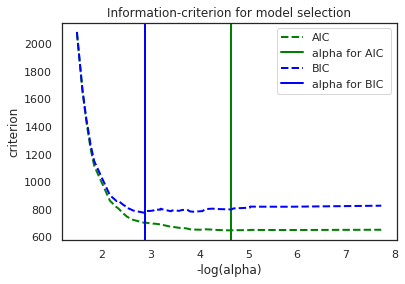

In [51]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train, y_train)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label= name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2,
                label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

In [52]:
lasso = Lasso(alpha = model_aic.alpha_) 
lasso.fit(X_train, y_train)

# Print R2 and MSE
print('Training r^2:', lasso.score(X_train, y_train))
print('Test r^2:', lasso.score(X_test, y_test))

Training r^2: 0.7160663479048328
Test r^2: 0.6995584814368063


/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.174792769858, tolerance: 1.0485040490533506



### Lasso Cross-validation

In [53]:
lasso_cv = LassoCV(cv=10, random_state=0).fit(X_train, y_train)

print('Training r^2:', lasso_cv.score(X_train, y_train))
print('Test r^2:', lasso_cv.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso_cv.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, lasso_cv.predict(X_test)))

Training r^2: 0.7145402499075486
Test r^2: 0.7019951963096899
Training MSE: 1.439661875005737
Test MSE: 1.5067007565691475


/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.847293811568761, tolerance: 1.0485040490533506



### Check the normality of the residuals

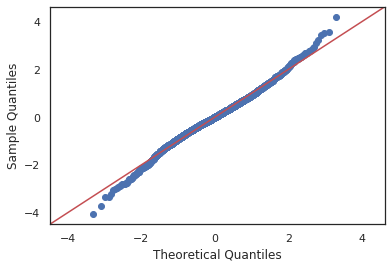

In [54]:
residuals = (lasso_cv.predict(X_train) - y_train)
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

The residuals look quite normal

### Most important features

In [55]:
coefficients = pd.Series(lasso_cv.coef_,index=features.values).to_dict()
abs_coefficients = {k: abs(v) for k, v in coefficients.items()}
coefs_ranked = OrderedDict(sorted(coefficients.items(), key=lambda kv: kv[1]))
top_5 = list(coefs_ranked)[:5]
print("The 5 most important coefficients are:")
print(" / ".join(top_5))

The 5 most important coefficients are:
%_Diabetic / %_Uninsured_children_^2 / %_Food_Insecure / Household_Median_Income_^3 / MV_Mortality_Rate


In [56]:
coefs_pos = {k: abs(v) for k, v in coefs_ranked.items() if v > 0}
coefs_neg = {k: abs(v) for k, v in coefs_ranked.items() if v < 0}
coefs_pos = OrderedDict(sorted(coefs_pos.items(), key=lambda kv: kv[1], reverse=True))



Biggest Negative Factors on Life Expectancy


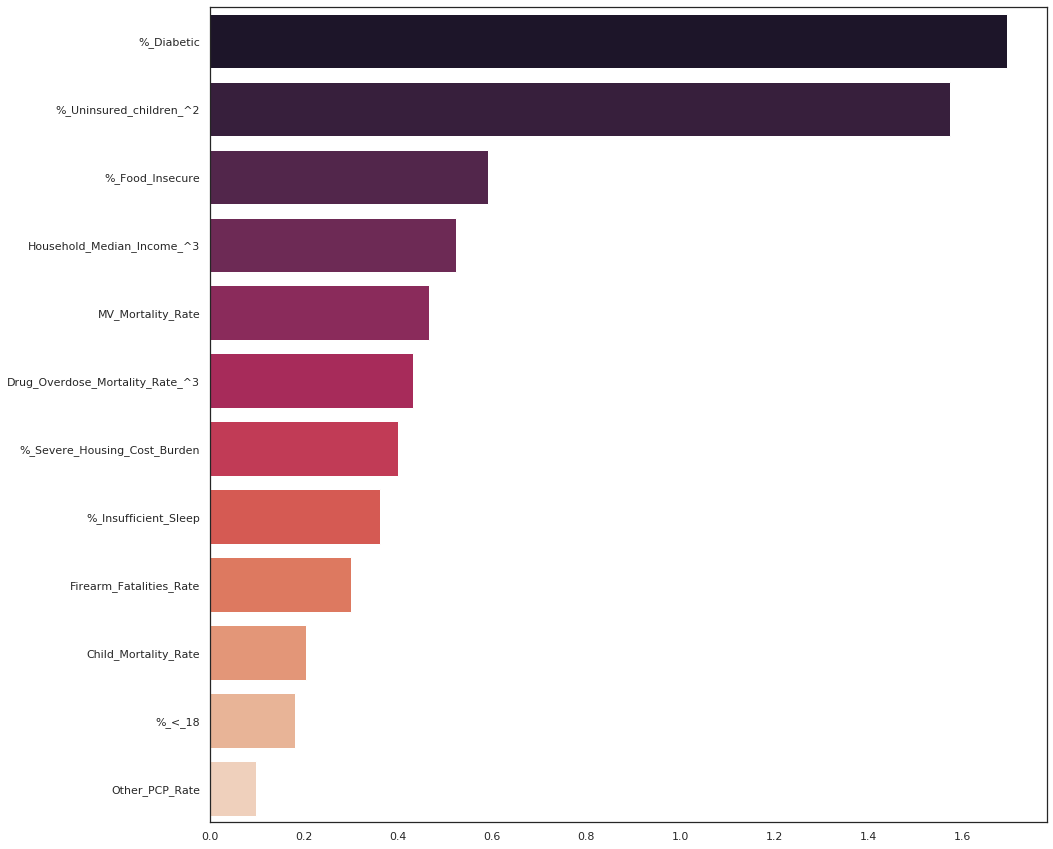

In [57]:
sns.set(rc={"figure.figsize":(15,15)})
sns.set_style("white")
sns.barplot(x=list(coefs_neg.values()), y=list(coefs_neg.keys()), palette="rocket")
print("\n\nBiggest Negative Factors on Life Expectancy")



Biggest Positive Factors on Life Expectancy


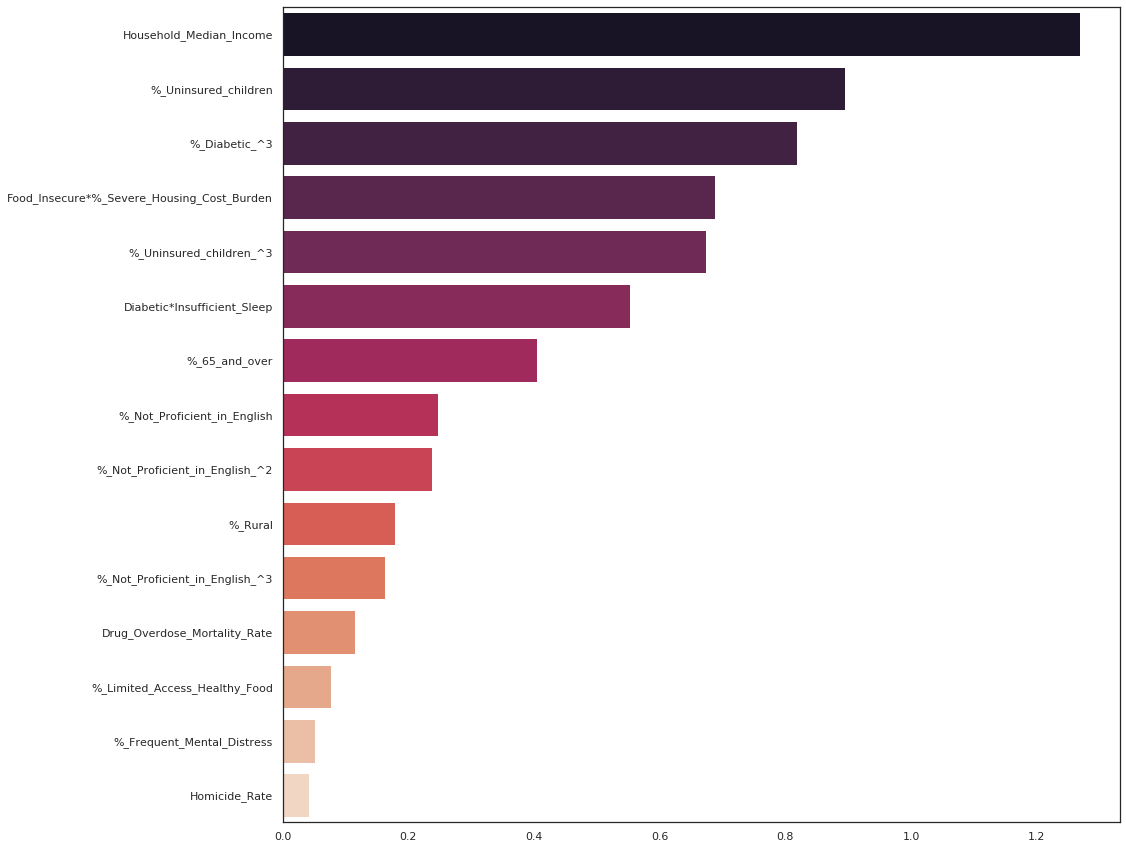

In [58]:
sns.set(rc={"figure.figsize":(15,15)})
sns.set_style("white")
sns.barplot(x=list(coefs_pos.values()), y=list(coefs_pos.keys()), palette="rocket")
print("\n\nBiggest Positive Factors on Life Expectancy")

# Conclusions

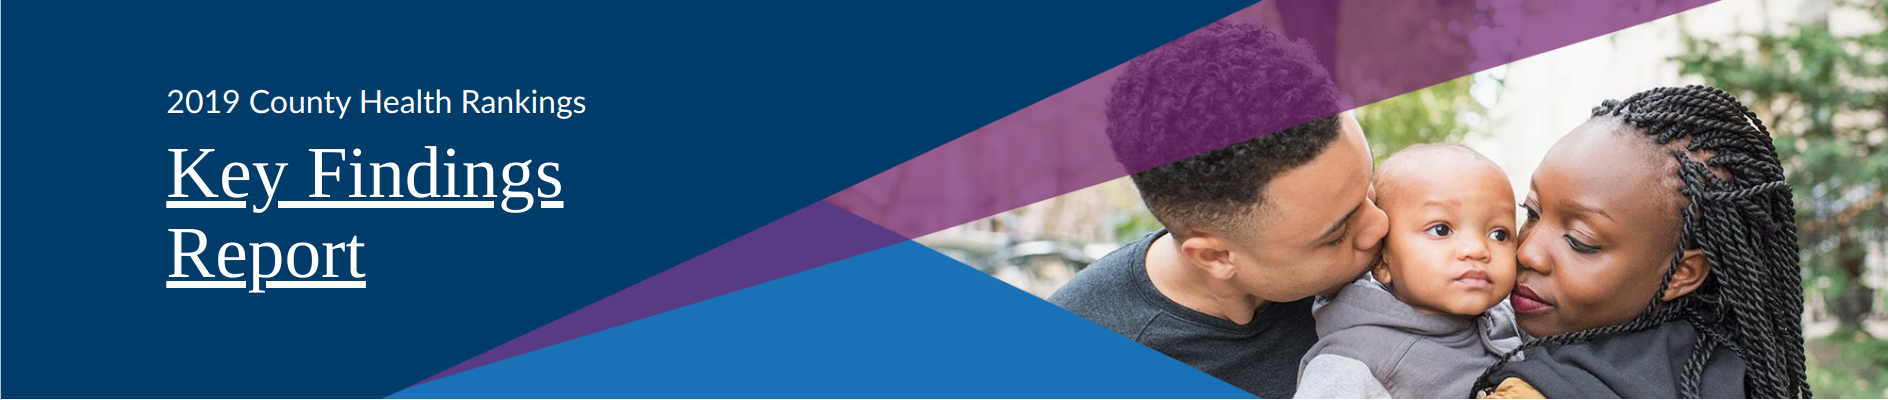

In [85]:
Image("Pictures/Findings Banner.png")

### The two most important factors on Life Expectancy in USA are the following:
- Diabetes (negative impact)
- Household Income (positive impact)

Heatmap of diabetics percentages in USA counties


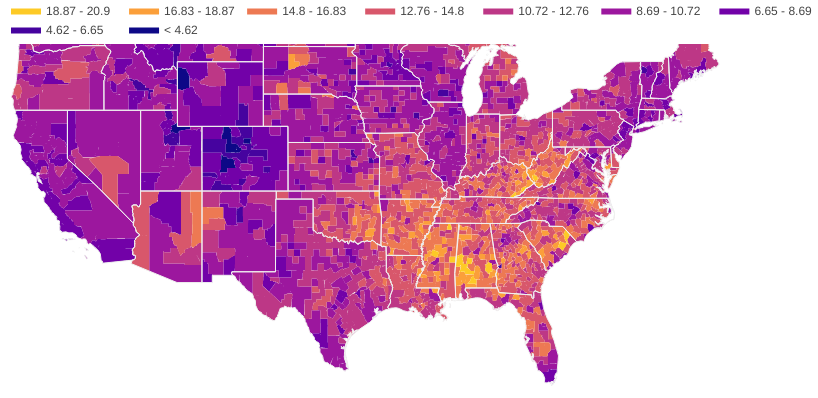

In [96]:
print("Heatmap of diabetics percentages in USA counties")
Image("Pictures/Diabetic.png")

Heatmap of House Holds median incomes in USA counties


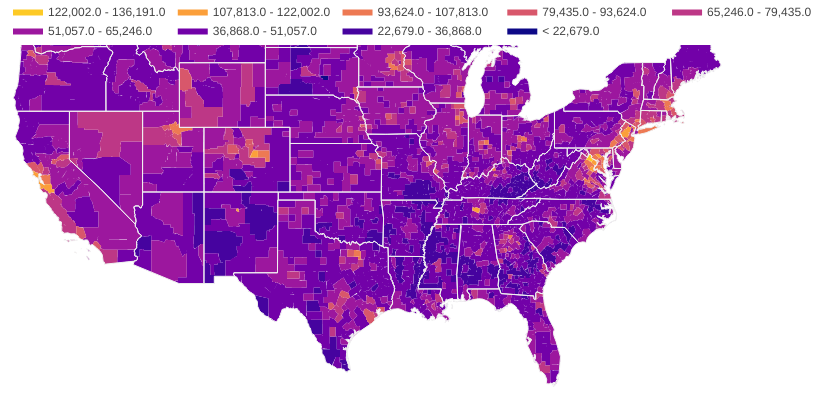

In [97]:
print("Heatmap of House Holds median incomes in USA counties")
Image("Pictures/Median_Income.png")

## Here are our proposed solutions to increase Life Expectancy in USA

#### Concerning Food Security
- Improve the access to Healthy Foods
- Campaign against fast food

#### Concerning Household Income
- Increase minimum wage in areas where the life expectancy is low
- Create higher paid jobs in areas where the life expectancy is low by lowering taxes for compagnies employing high-skilled labors
- Reduce taxes for poor people